In [1]:
import matplotlib.pyplot as plt
import numpy as np
from typing import Tuple, Dict

## Nahrej ze souboru data a vrať je

In [2]:
def _extract_meta(file_name: str) -> Tuple[float, float, float]:
    """z=7.5cm_P0=10uW_PM=29.78mW -> z, P0, PM"""
    return [float(e.split("=")[1][:-2]) for e in file_name.split("_")]

def fetch(path: str) -> Dict:
    x_arr = [] # v mm
    P_arr = [] # v mW
    z, P0, PM = _extract_meta(os.path.basename(path).strip(".csv")) # v cm, uW, mW
    with open(path, "r") as f:
        f.readline()
        while line := f.readline():
            x, P = [float(i) for i in line.split(";")]
            x_arr.append(x) 
            P_arr.append(P)
    return {
        "z": z * 10, # cm -> mm
        "P0": P0 *10**(-3), # uW -> mW
        "PM": PM,
        "x": x_arr,
        "P": P_arr
    } 

## Vypočti X0
x0 je poloha při které jsme ve středu svazku. Tj výkon je přesně v polovině maxima!

In [3]:
def linear_aprox(p1, p2, x1, x2, p_val) -> float:
    a = (p1 - p2) / (x1 - x2)
    b = p1 - a*x1
    x_val = (p_val - b) / a
    return x_val 

def get_x0(x: list, P: list, PM: float):
    p_closest = min(P, key=lambda p: abs(p-PM/2))
    i_bef = -1
    if p_closest < PM/2:
        i_bef = P.index(p_closest)
    elif p_closest > PM/2:
        i_bef = P.index(p_closest) - 1
    else:
        return x[P.index(p_closest)]
    # from values around half power approximates x for half the power, hence the center of the beam
    return linear_aprox(P[i_bef], P[i_bef + 1], x[i_bef], x[i_bef + 1], PM/2)

In [4]:
import os 
DATA_DIRECTORY = r"C:\Users\david\OneDrive\Plocha\škola\páťák\Diplomová práce\Měření\beam-shape-knife-edge"
INPUT_DATA = []
for file in [f for f in os.listdir(DATA_DIRECTORY) if f.endswith(".csv")]:
    data = fetch(os.path.join(DATA_DIRECTORY, file))
    data["x0"] = get_x0(data["x"], data["P"], data["PM"])
    INPUT_DATA.append(data)
print(f"Sucesfully loaded {len(INPUT_DATA)} files, which goes followingly:")
INPUT_DATA = sorted(INPUT_DATA, key=lambda x: x['z'])
for data in INPUT_DATA:
    print(f"z={data['z']}mm P0={data['P0']}mW PM={data['PM']}mW x0={data['x0']}mm")



Sucesfully loaded 5 files, which goes followingly:
z=75.0mm P0=0.01mW PM=29.78mW x0=4.526495726495726mm
z=125.0mm P0=0.01mW PM=29.78mW x0=3.8720125786163524mm
z=1238.0mm P0=0.05mW PM=25.65mW x0=4.206914893617021mm
z=1338.0mm P0=0.05mW PM=25.65mW x0=5.185364208633093mm
z=1488.0mm P0=0.03mW PM=25.4mW x0=4.532894736842104mm


## Fitování dat na křivku výkonu
Viz https://people.fjfi.cvut.cz/blazejos/public/ul7en.pdf
$$
    P = P_0 + \frac{P_{max}}{2}(1 - erf(\frac{\sqrt{2}(x - x_0)}{w}))
$$

In [5]:
from scipy.optimize import curve_fit
from scipy import special

def power_fit_function(x: list, w: float, x0: float, P0: float, PM: float):
    return P0 + (PM/2) * (1 + special.erf(np.sqrt(2) * (x - x0) / w))

z=75.0 w=0.9592893722305507


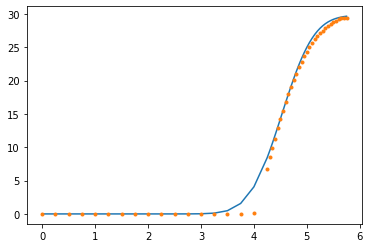

z=125.0 w=0.8275495429457659


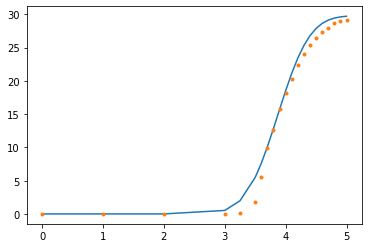

z=1238.0 w=0.6251388716849647


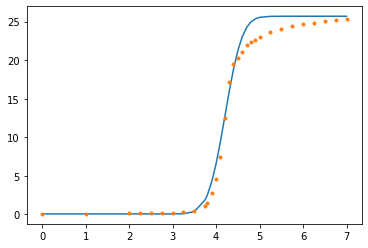

z=1338.0 w=0.6503403928450112


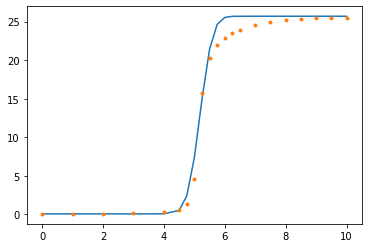

z=1488.0 w=0.9349864319976051


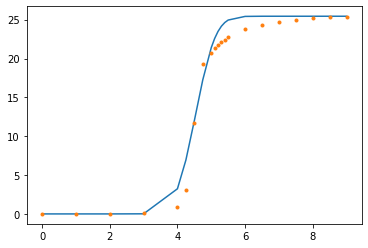

In [17]:
w_arr = []
for data in INPUT_DATA:
    fit_func = lambda x, w: power_fit_function(x, w, x0=data["x0"], P0=data["P0"], PM=data["PM"])
    popt, _ = curve_fit(fit_func, data["x"], data["P"])
    w, *_= popt
    print(f"z={data['z']} w={w}")
    w_arr.append(w)
    plt.plot(data["x"], [fit_func(x, w) for x in data["x"]], "-")
    plt.plot(data["x"], data["P"], ".")
    plt.show()

w_arr = np.array(w_arr)

## Vývoj poloměru svzaku při propagaci

w_loc=439.0847940362943


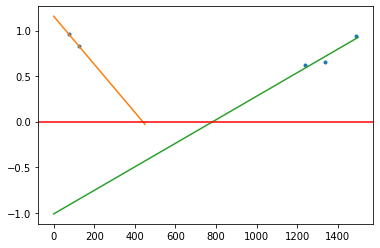

In [19]:
z_arr = np.array([d['z'] for d in INPUT_DATA])

a, b = np.polyfit(z_arr[:2], w_arr[:2], deg=1)
w_loc = -b/a
print(f"w_loc={w_loc}")

c, d = np.polyfit(z_arr[2:], w_arr[2:], deg=1)



plt.plot(z_arr, w_arr, ".")
plt.plot(np.linspace(0,450), np.polyval([a, b], np.linspace(0,450)), "-")
plt.plot(np.linspace(0,1500), np.polyval([c, d], np.linspace(0,1500)), "-")
plt.axhline(y=0, color='r', linestyle='-')
plt.show()

Jelikož první dvě měření relativně dobře odpovídají teorii, tak budu počítat s nimi (není ideálí, ale v tuto chvíli nic lepšího nemám (??))

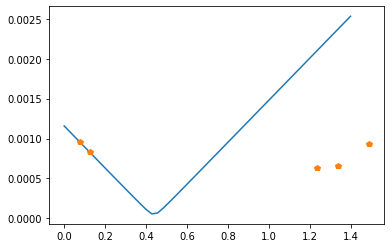


        amplitude	=	1,
        wavelength	=	405.0 nm,
        waist_loc	=	43.90847940362951 cm,
        waist_rad	=	0.04892818023251561 mm,
        rayleigh_r	=	18.570045870046588 mm,
        divergence	=	-2.6347904886673748 mrad
        


In [22]:
from optix.beams import GaussianBeam
z_arr_chosen = np.array(z_arr[:2]) * 10**(-3)
w_arr_chosen = np.array(w_arr[:2]) * 10**(-3)

a, b = np.polyfit(z_arr_chosen, w_arr_chosen, deg=1)

w_loc = -b/a 
div = np.arctan(a)

# wavelength in milimeers
gb = GaussianBeam(405e-9, waist_location=w_loc, div=div)
z_est_arr = np.linspace(0, 1.4)
w_est_arr = gb.beam_radius(z_est_arr)
plt.plot(z_est_arr, w_est_arr)
plt.plot(z_arr*10**(-3), w_arr*10**(-3), "p")
plt.show()

print(gb)
